In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image
import scipy.spatial.distance as dist
from itertools import product
import sys

print('Modules imported')
np.set_printoptions(suppress=True)

Modules imported


Algorithm Computation: 
Get all photos, sort, and get Average face

In [2]:
images = {} #this will store images of each person
#loading all images into the "images" dictionary
size = 100
height = 100
width = 100
num_faces = 0

for image_str in os.listdir('raj_faces'):
    if(len(image_str) == 8):
        num_faces+=1
        if images.get('raj',0) == 0:
            images['raj'] = []
        img = Image.open('raj_faces/'+image_str)
        new_img = img.resize((size,size))    #resize all pics to same size
        images['raj'].append(new_img.convert('L'))

for image_str in os.listdir('alex'):
    
    if(len(image_str) == 10):
        num_faces+=1
        if images.get('alex',0) == 0:
            images['alex'] = []
        img = Image.open('alex/'+image_str)
        new_img = img.resize((size,size))    #resize all pics to same size
        images['alex'].append(new_img.convert('L'))
        
sum_face = np.zeros((height, width))
for image in images:
    num_of_imgs = 0
    for individual in images[image]:
        num_of_imgs +=1
        sum_face+=np.array(individual)
avg_face=sum_face/num_faces

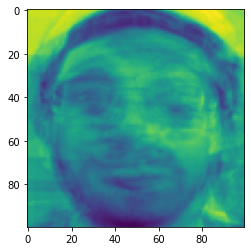

In [3]:
plt.imshow(avg_face)
plt.show()

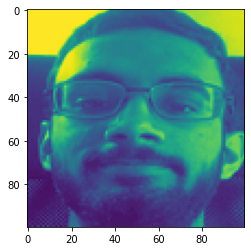

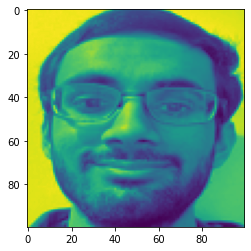

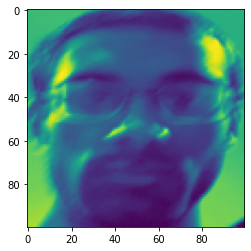

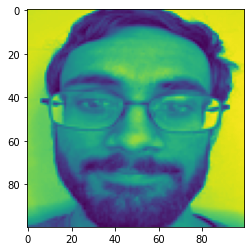

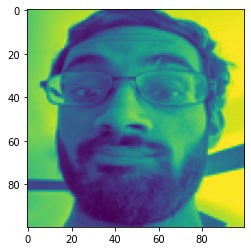

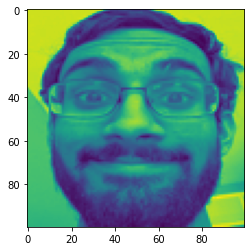

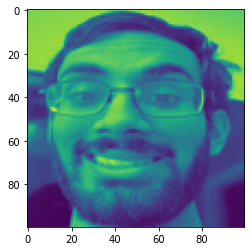

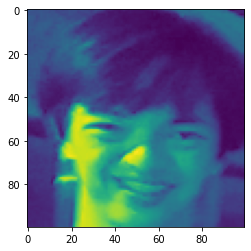

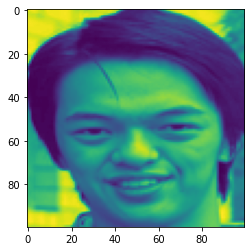

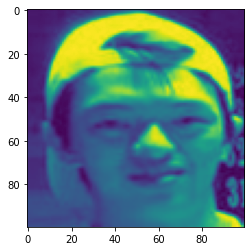

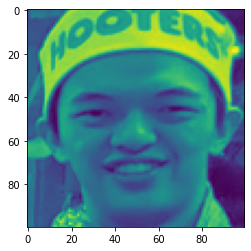

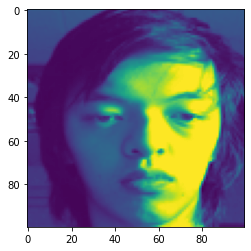

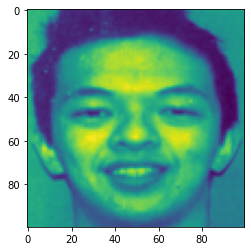

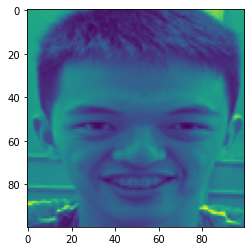

In [4]:
for key in images.keys():
    for i in range(len(images[key])):
        plt.imshow(images[key][i].convert('L'))
        plt.show()

Find difference between each face and average face

In [5]:
phi_i = np.empty((num_faces,height*width))
face_idx = 0
for image in images:
    for orig_face in images[image]:   #orig_face is Gamma
        phi_i[face_idx] = (np.array(orig_face)-avg_face).flatten()
        face_idx+=1
print(phi_i.shape)

(14, 10000)


Compute Covariance

In [6]:
C = phi_i.dot(phi_i.T)
print(C.shape)

(14, 14)


Find eigens

In [7]:
eigvals, eigvects = np.linalg.eigh(C)
#Normalize
eigvals = eigvals/np.linalg.norm(eigvals)
eigvects = eigvects/np.linalg.norm(eigvects)
print(eigvects.shape)

idx_sort = eigvals.argsort()[::-1]
print(idx_sort)
eigvects = eigvects[:,idx_sort]
print(eigvects.shape)

(14, 14)
[13 12 11 10  9  8  7  6  5  4  3  2  1  0]
(14, 14)


In [8]:
K=9
#K=(num_faces//5)
evals_K = eigvals[:K]
evects_K = eigvects[:K,:]
print(evals_K.shape)
print(evects_K.shape)


(9,)
(9, 14)


In [9]:
print(evects_K.shape)
evects_K = evects_K.dot(phi_i)
for i in range(K):
    evects_K[i,:] = evects_K[i,:]/np.linalg.norm(evects_K[i,:])
print(evects_K.shape)

(9, 14)
(9, 10000)


In [10]:
w = evects_K.dot(phi_i.T)
# print(w)
print(w.shape)


(9, 14)


Face Recognition

In [11]:
test_faces = {}
for image_str in os.listdir('test'):
    name_arr = image_str.split('-')
    name = name_arr[0] +' ' + name_arr[1]
    img = Image.open('test/'+image_str)
    img = img.resize((width,height)).convert('L')
    test_faces[name] = img.convert('L')
    
print(test_faces)

{'alex pic': <PIL.Image.Image image mode=L size=100x100 at 0x2627ABB1F88>, 'leonardo dicaprio': <PIL.Image.Image image mode=L size=100x100 at 0x262784C6D88>, 'matt damon': <PIL.Image.Image image mode=L size=100x100 at 0x2627ABB1D08>, 'red apple': <PIL.Image.Image image mode=L size=100x100 at 0x262784D3508>, 'toilet pic': <PIL.Image.Image image mode=L size=100x100 at 0x262784D3408>, 'will smith': <PIL.Image.Image image mode=L size=100x100 at 0x2627ABA7BC8>}


8
1.5830279823993033e-12


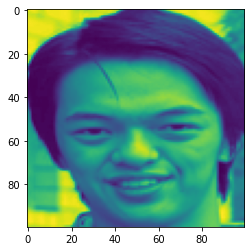

alex pic
We classify this as a face
---
12
3296.351004984128


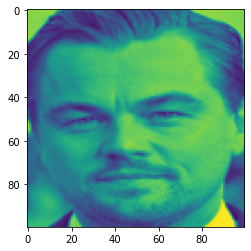

leonardo dicaprio
We classify this as a face
---
12
3448.066404368582


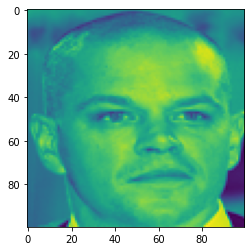

matt damon
We classify this as a face
---
4
7027.663745252675


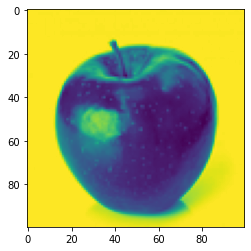

red apple
We classify this as a face
---
3
5344.858601309619


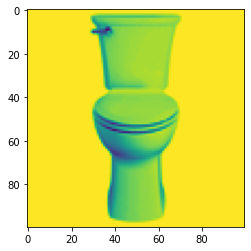

toilet pic
We classify this as a face
---
12
4497.03659273551


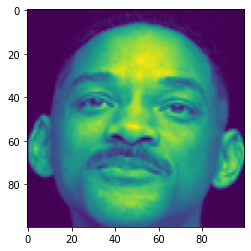

will smith
We classify this as a face
---


In [12]:
##DISREGARD
phi = np.empty((num_faces,height*width))
for faces in test_faces:
    phi = (test_faces[faces] - avg_face).reshape(width*height,1)
    W = evects_K.dot(phi)
    omega_norms = dist.cdist(w.T,W.T, 'euclidean')
    e = np.argmin(omega_norms)
    print(e)
    print(np.min(omega_norms))
    plt.imshow(test_faces[faces])
    plt.show()
        
    idx = np.argmin(omega_norms)
    detection_threshold = 20000
    recognition_threshold = 7000
    print(faces)
    if omega_norms[idx] <detection_threshold:
        print("We classify this as a face")
#         if avg_norms[idx]<recognition_threshold:
#             print("We classify this as", list(test_faces)[idx])
#         else:
#             print("We classify this as an unknown person")
    else:
        print("We classify this as not a face")
    print('---')

In [24]:
def facial_detection(faces):
    phi = np.empty((num_faces,height*width))

    phi = (faces - avg_face).reshape(width*height,1)
    W = evects_K.dot(phi)
    omega_norms = dist.cdist(w.T,W.T, 'euclidean')
    e = np.argmin(omega_norms)
    print(e)
    print(np.min(omega_norms))
    plt.imshow(faces)
    plt.show()

    idx = np.argmin(omega_norms)
    detection_threshold = 4500
    recognition_threshold = 7000
    if omega_norms[idx] <detection_threshold:
        print("We classify this as a face")
    #         if avg_norms[idx]<recognition_threshold:
    #             print("We classify this as", list(test_faces)[idx])
    #         else:
    #             print("We classify this as an unknown person")
        return True
    else:
        print("We classify this as not a face")
        return False

alex pic
8
1.5830279823993033e-12


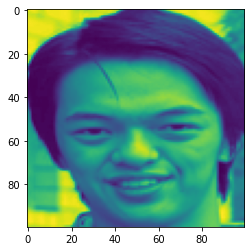

We classify this as a face
leonardo dicaprio
12
3296.351004984128


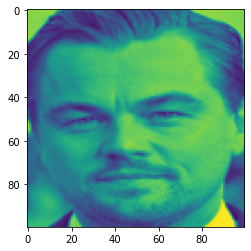

We classify this as a face
matt damon
12
3448.066404368582


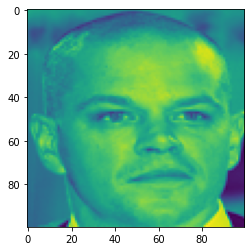

We classify this as a face
red apple
4
7027.663745252675


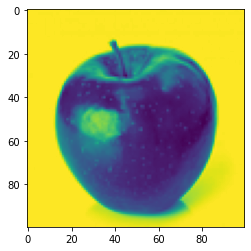

We classify this as not a face
toilet pic
3
5344.858601309619


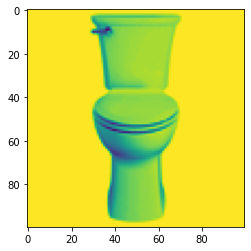

We classify this as not a face
will smith
12
4497.03659273551


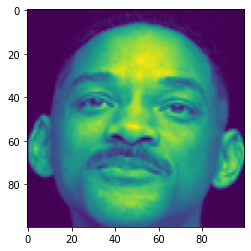

We classify this as a face


In [25]:
for faces in test_faces:
    print(faces)
    facial_detection(test_faces[faces])


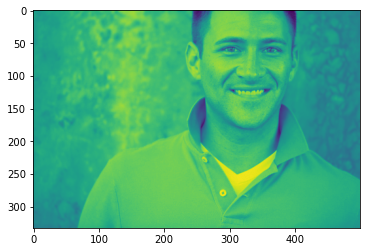

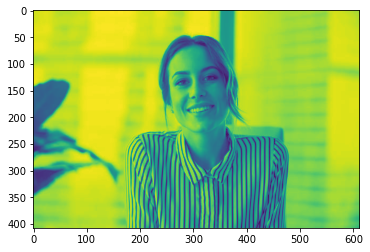

In [15]:
current_dir = 'full_images'
full_img = {}
for image_str in os.listdir(current_dir):
    img = Image.open(current_dir+'/'+image_str)
    full_img[image_str]=img.convert('L')
    plt.imshow(full_img[image_str])
    plt.show()


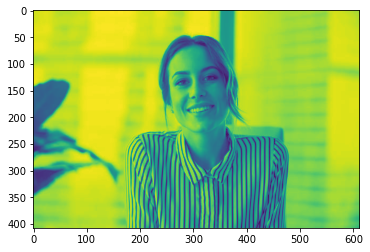

[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835
   2175.00274279]
 [-2913.4

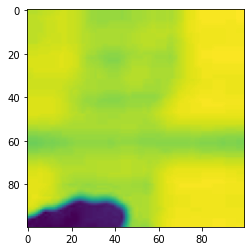

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


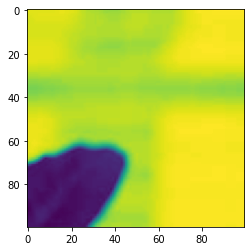

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


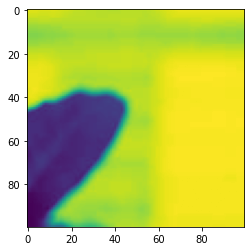

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


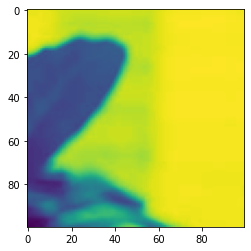

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


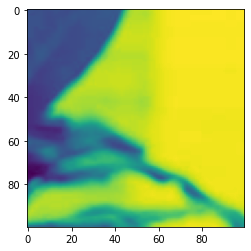

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


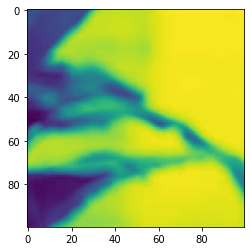

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


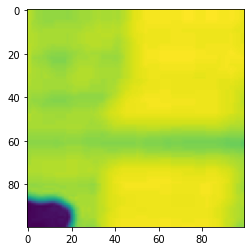

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


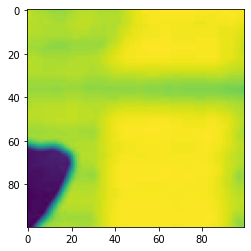

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


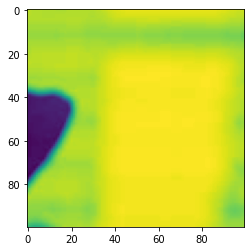

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


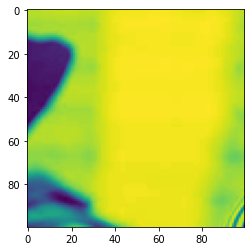

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


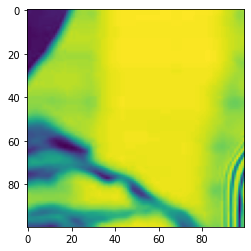

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


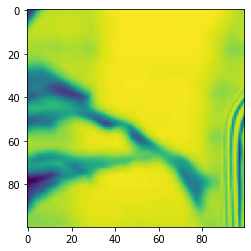

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


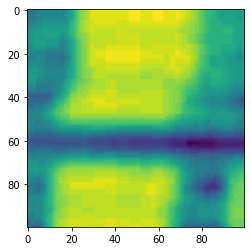

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


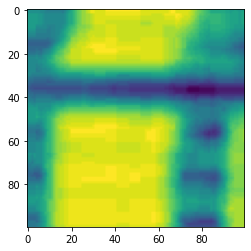

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


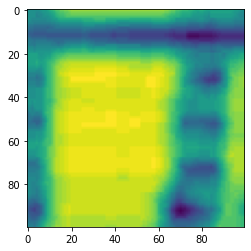

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


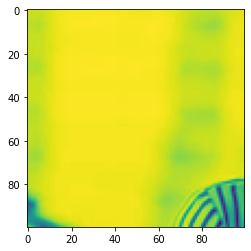

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


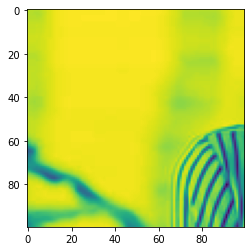

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


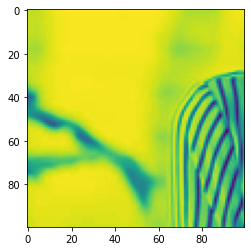

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


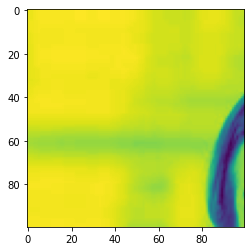

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


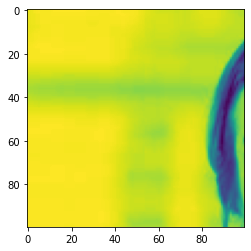

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


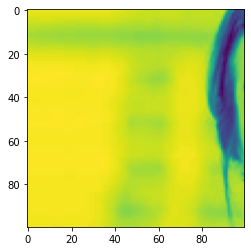

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


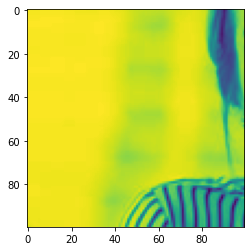

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


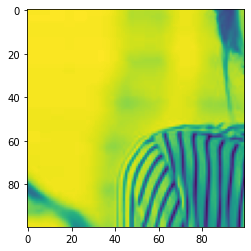

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


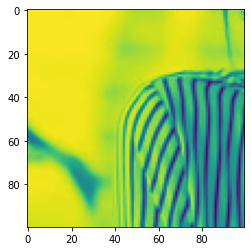

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


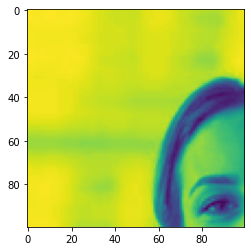

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


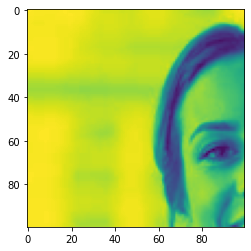

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


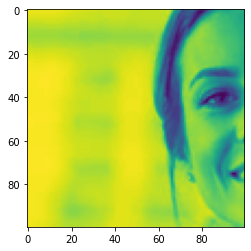

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


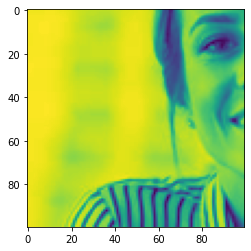

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


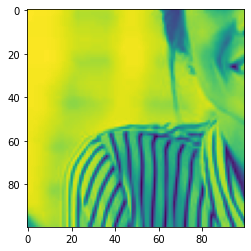

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


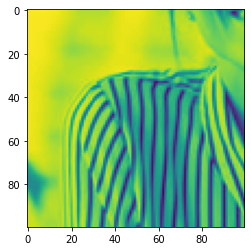

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


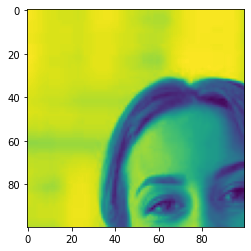

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


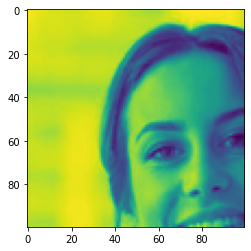

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


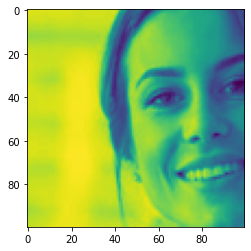

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


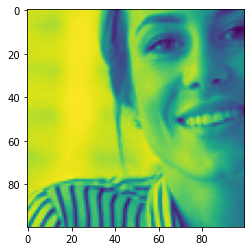

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


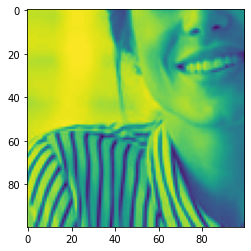

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


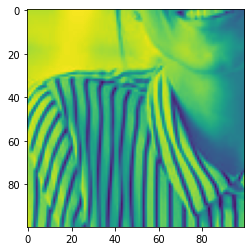

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


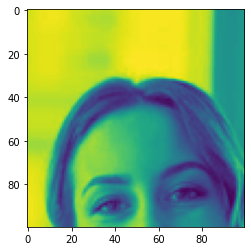

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


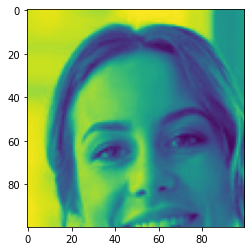

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


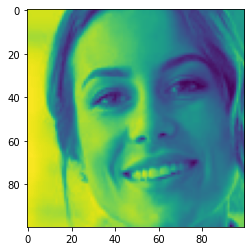

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


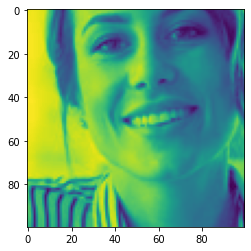

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


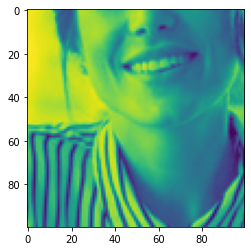

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


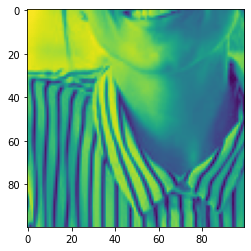

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


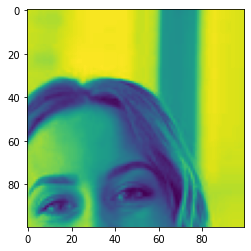

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


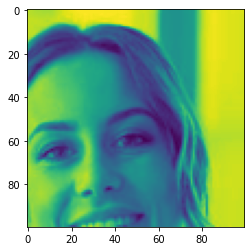

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


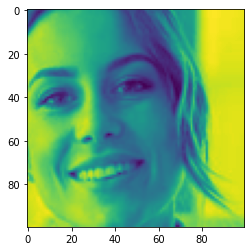

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


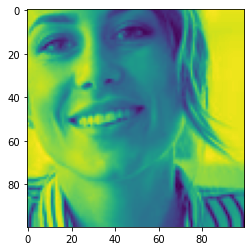

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


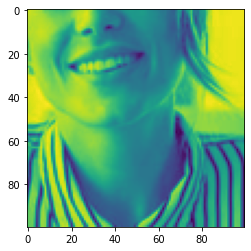

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


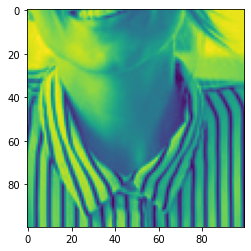

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


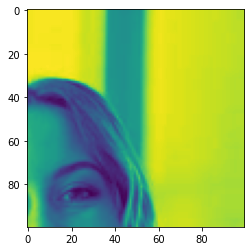

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


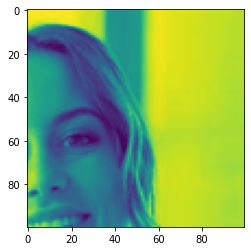

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


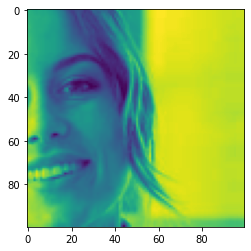

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


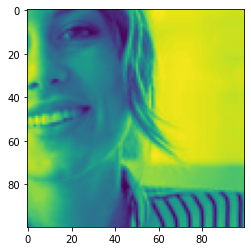

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


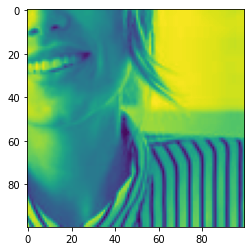

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


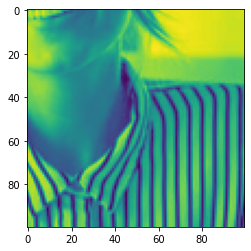

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


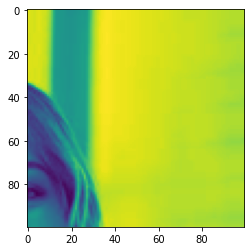

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


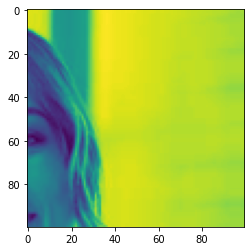

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


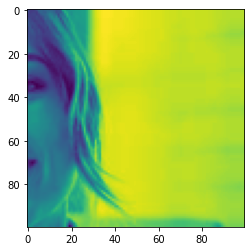

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


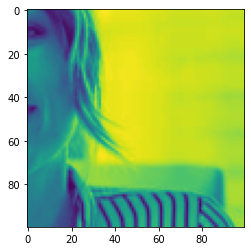

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


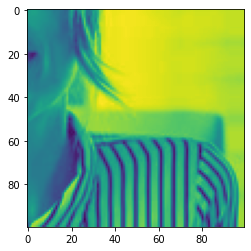

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


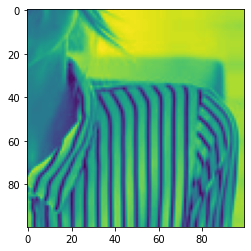

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


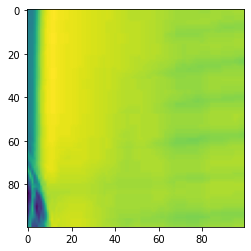

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


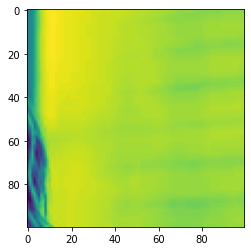

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


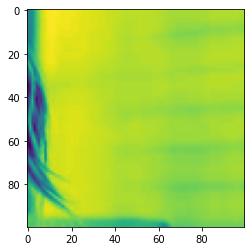

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


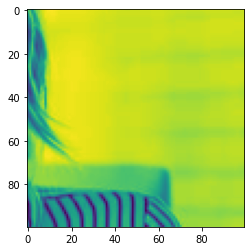

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


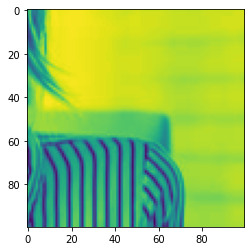

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


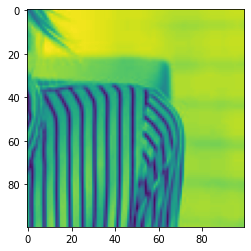

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


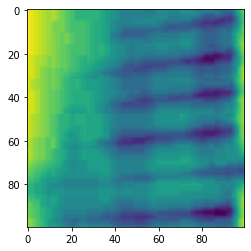

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


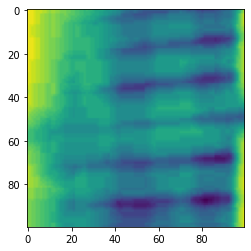

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


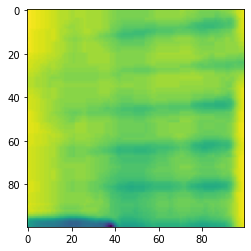

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


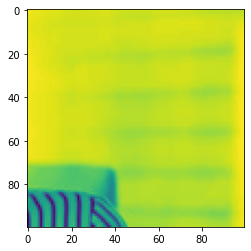

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


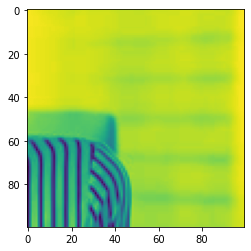

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


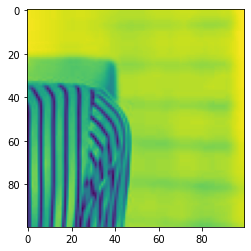

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


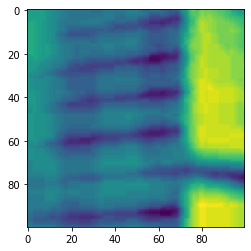

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


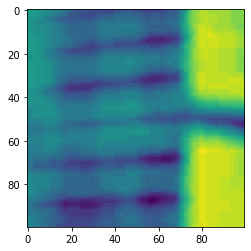

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


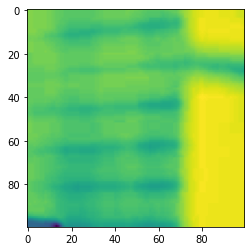

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


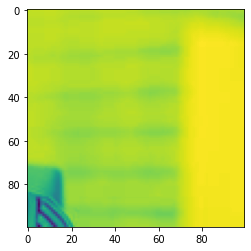

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


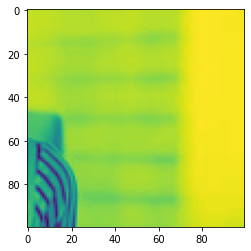

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


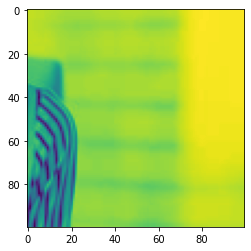

We classify this as a face


In [16]:
img = full_img['one_woman.jpg']
plt.imshow(img)
plt.show()

img_w = 150
img_h = 150
boxes = []
for i in range(0,img.width,int(img_w/4)):
    for j in range(0,img.height//2,int(img_h/4)):
        right = min((i+img_w),img.width)
        upper = j
        left = i
        lower = min((j + img_h),img.height)
        if right - left < img_w or lower-upper < img_h:
            continue
        bbox = (left,upper,right,lower)
        crop = img.crop(bbox).resize((width,height)).convert('L')
        #print(bbox)
#         plt.imshow(crop)
#         plt.show()
        if facial_detection(crop):
            boxes.append([left,right,upper,lower])

In [17]:
def should_merge(box1, box2,close_dist):
    a = (box1[0], box1[2]), (box1[1], box1[3])
    b = (box2[0], box2[2]), (box2[1], box2[3])

    if any(abs(a_v - b_v) <= close_dist for i in range(2) for a_v, b_v in product(a[i], b[i])):
        return True, [min(*a[0], *b[0]), min(*a[1], *b[1]), max(*a[0], *b[0]), max(*a[1], *b[1])]

    return False, None

def merge_box(boxes, close_dist = 100):
    for i, box1 in enumerate(boxes):
        for j, box2 in enumerate(boxes[i + 1:]):
            is_merge, new_box = should_merge(box1, box2,close_dist)
            if is_merge:
                boxes[i] = None
                boxes[j] = new_box
                break

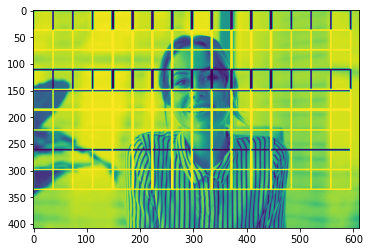

In [18]:
temp_img = img
for i in range(len(boxes)):
    if(boxes[i] == None):
        continue
    start_point = (boxes[i][0], boxes[i][2]) 

    # represents the bottom right corner of rectangle 
    end_point = (boxes[i][1], boxes[i][3]) 

    # Blue color in BGR 
    color = (255*(i%3), 255*(i+1%3),255*(i+2%3)) 

    # Line thickness of 2 px 
    thickness = 2

    # Using cv2.rectangle() method 
    # Draw a rectangle with blue line borders of thickness of 2 px 
    np_img = np.asarray(temp_img)
    image = cv2.rectangle(np_img, start_point, end_point, color, thickness) 
    temp_img = Image.fromarray(image)
plt.imshow(image)
plt.show()


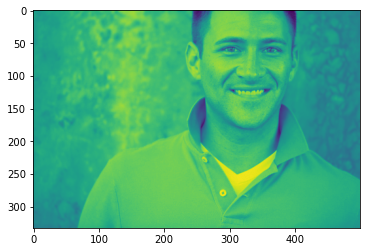

[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835
   2175.00274279]
 [-2913.4

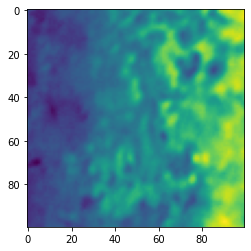

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


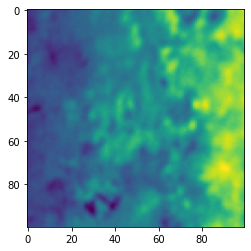

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


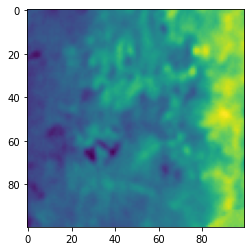

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


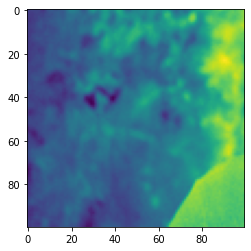

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


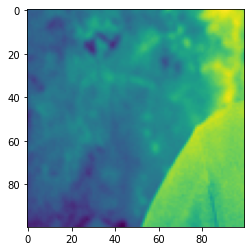

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


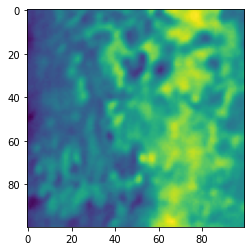

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


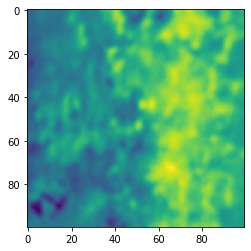

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


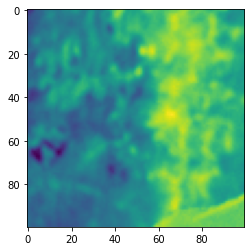

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


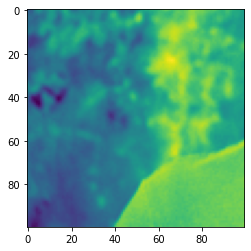

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


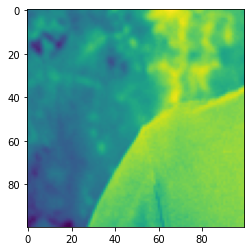

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


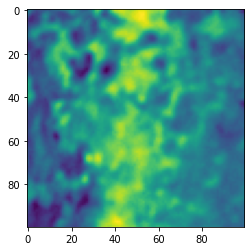

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


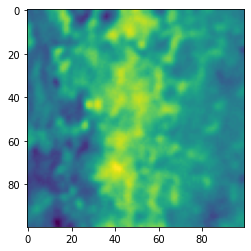

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


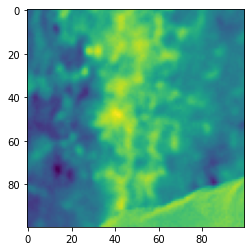

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


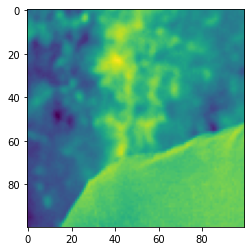

We classify this as a face
[[ 1920.2034799    147.32658343   163.30741538  -740.27889537
  -1980.30317092 -1712.45818998 -1121.34916444  1777.78394541
   1107.75167497]
 [ 1685.90405426   293.65627593  2507.70318454   465.18916522
    237.75819276   459.89264725 -1842.20248859   950.09452204
  -1839.23623682]
 [ -153.20862232   546.22168761  1487.23155474   182.5154508
  -1570.26500374  -578.08454552   481.62196411  2592.2166877
  -1150.77224599]
 [  611.29056442  -601.62804305  3718.57260982  1393.82819954
   1621.75474677   846.80125308 -4624.59288557  3019.27935529
  -3151.33380026]
 [ 1477.58417976  -761.10174901  4566.54161695  1475.85636773
   2199.83685542   505.40712336 -4074.99195452  4972.15999274
  -5733.98413963]
 [ 2214.30012317  1054.03119595  2830.22969743  1440.60575813
   -346.07475222  1100.53475695 -3279.52793213  2652.08584785
  -3311.75988592]
 [ 4121.32909449   758.33947559  1588.25655214 -1586.2850219
   -764.61781672  -877.48032776   175.08110311  -634.44129835


KeyboardInterrupt: 

In [19]:
img2 = full_img['one_man.jpg']
plt.imshow(img2)
plt.show()

img_w = 150
img_h = 150
boxes = []
for i in range(0,img2.width,int(img_w/4)):
    for j in range(0,img2.height//2,int(img_h/4)):
        right = min((i+img_w),img2.width)
        upper = j
        left = i
        lower = min((j + img_h),img.height)
        if right - left < img_w or lower-upper < img_h:
            continue
        bbox = (left,upper,right,lower)
        crop = img2.crop(bbox).resize((width,height)).convert('L')
        #print(bbox)
#         plt.imshow(crop)
#         plt.show()
        if facial_detection(crop):
            boxes.append([left,right,upper,lower])

In [ ]:
temp_img = img2
for i in range(len(boxes)):
    if(boxes[i] == None):
        continue
    start_point = (boxes[i][0], boxes[i][2]) 

    # represents the bottom right corner of rectangle 
    end_point = (boxes[i][1], boxes[i][3]) 

    # Blue color in BGR 
    color = (255*(i%3), 255*(i+1%3),255*(i+2%3)) 

    # Line thickness of 2 px 
    thickness = 2

    # Using cv2.rectangle() method 
    # Draw a rectangle with blue line borders of thickness of 2 px 
    np_img = np.asarray(temp_img)
    image = cv2.rectangle(np_img, start_point, end_point, color, thickness) 
    temp_img = Image.fromarray(image)
plt.imshow(image)
plt.show()
